In [1]:
import pandas as pd
from datetime import datetime
from zoe import cases, query, pickle, find_previous, plot_study, plot_study_evolution

In [2]:
uk_active_cases = query("SELECT * FROM uk_active_cases", index='date')
uk_active_cases.index = pd.to_datetime(uk_active_cases.index, format='%Y%m%d')
uk_active_cases

,cartodb_id,the_geom,the_geom_webmercator,corrected_covid_positive
date,,,,
2020-06-12,71228,None,None,86085.715275
2020-06-13,71229,None,None,79940.811469
2020-06-14,71230,None,None,74244.112992
2020-06-15,71231,None,None,68878.187593
2020-06-16,71232,None,None,64137.552455
...,...,...,...,...
2021-06-19,71600,None,None,213573.009432
2021-06-20,71601,None,None,221245.880319
2021-06-21,71602,None,None,228786.878122


In [3]:
curr_date = uk_active_cases.index.max()
print(pickle(uk_active_cases, 'uk_active_cases', curr_date))

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-06-23_2021-06-23-20-10.pickle


In [4]:
prev_date, prev_uk_active_cases = find_previous(curr_date)

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-06-22_2021-06-22-17-32.pickle


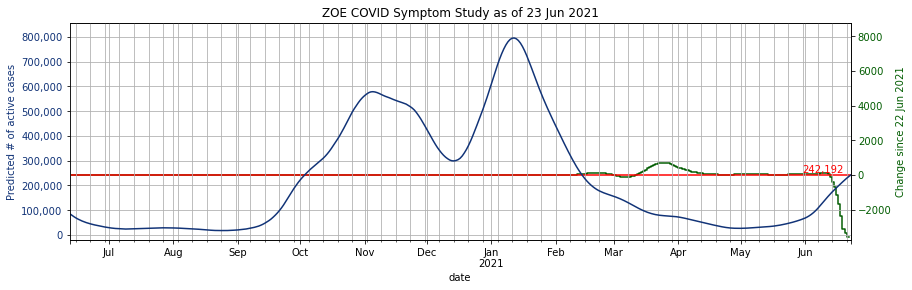

In [5]:
plot_study(curr_date, prev_date, uk_active_cases, prev_uk_active_cases)

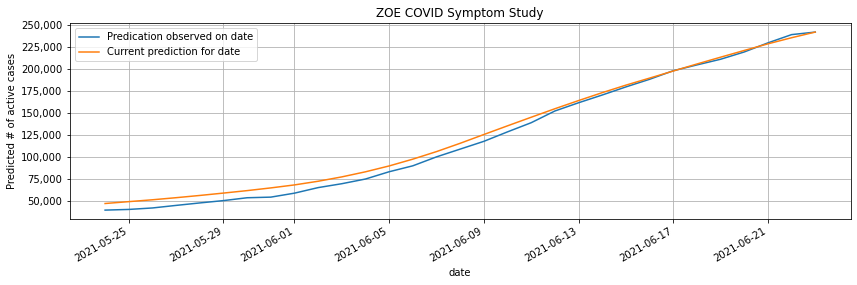

In [6]:
plot_study_evolution(curr_date, days=30)

In [7]:
prevalence_map = query("SELECT * FROM prevalence_map")
prevalence_map['percentage'] = prevalence_map['percentage'].astype(float)

In [8]:
for_date, = prevalence_map['data_status'].unique()
print(pickle(prevalence_map, 'prevalence_map', datetime.strptime(for_date, '%H:%M:%S %d-%m-%Y')))

/Users/chris/coronavirus/data/zoe_prevalence_map_2021-06-23_2021-06-23-20-10.pickle


In [9]:
prevalence_map[['lad16nm', 'lad16cd', 'percentage']].sort_values('percentage', ascending=False)[:10]

,lad16nm,lad16cd,percentage
313,Aberdeen City,S12000033,2.972815
164,Chorley,E07000118,2.431052
268,Oldham,E08000004,1.784883
176,South Ribble,E07000126,1.640831
306,Midlothian,S12000019,1.548439
276,Liverpool,E08000012,1.527778
171,Preston,E07000123,1.493320
285,South Tyneside,E08000023,1.438505
235,Manchester,E08000003,1.322114
287,Birmingham,E08000025,1.186341
